# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from network import Net
from diff_equation import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(10)

# Training Data

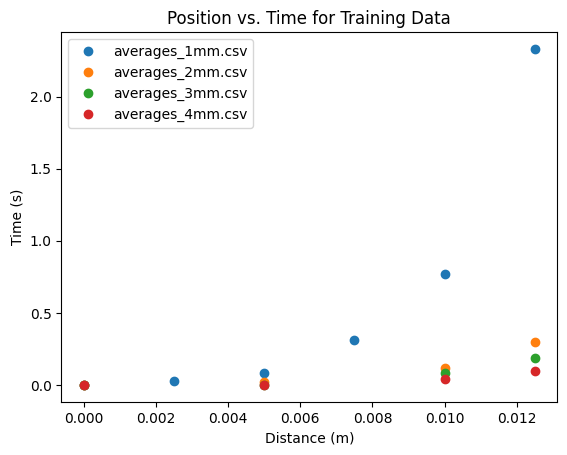

In [5]:
# Grab training data
train, test, legend = grab_training_data()

# Plot training data
for i in range(0, len(train)):
    plt.plot(train[i]['DISTANCE'], train[i]['TIME'], 'o')
plt.legend(legend)
plt.ylabel('Time (s)')
plt.xlabel('Distance (m)')
plt.title('Position vs. Time for Training Data')
plt.show()

# Run the Model

Losses for 1mm droplet:
Epoch 1/6000, total loss: 147019808.0
Epoch 2/6000, total loss: 147019632.0
Epoch 3/6000, total loss: 147019472.0
Epoch 4/6000, total loss: 147019264.0
Epoch 5/6000, total loss: 147019040.0
Epoch 6/6000, total loss: 147018784.0
Epoch 7/6000, total loss: 147018448.0
Epoch 8/6000, total loss: 147018048.0
Epoch 9/6000, total loss: 147017584.0
Epoch 10/6000, total loss: 147017024.0
Epoch 600/6000, total loss: 100782488.0
Epoch 1200/6000, total loss: 100781648.0


KeyboardInterrupt: 

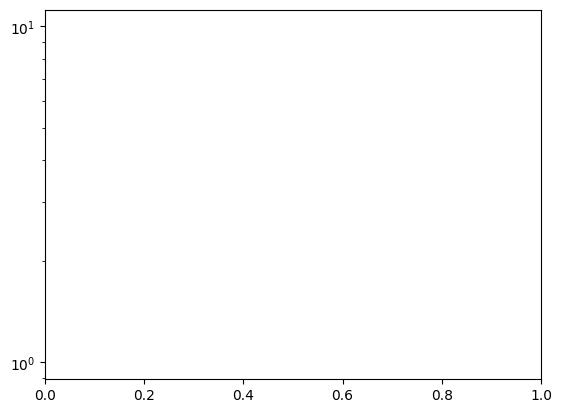

In [6]:
num_epochs = 6000
data_loss_weight = 1
physics_loss_weight = 1
lr = 8*1e-4
batch_size = 8

'''
Train model for each droplet size, plot losses for each one.
Change the bounds on this loop and subsequent ones from '0', 'len(different_droplet_networks)' to '0', '1' to do only the 1mm droplet.
You can change the bounds similarly to only train the network for other-sized droplets.
'''
plt.yscale('log')
different_droplet_networks = [None] * len(train)

for i in range(0, len(different_droplet_networks)):
    different_droplet_networks[i] = Net(1, 1, droplet_size_idx=i, loss2=physics_loss_dim, epochs=num_epochs, loss1_weight=data_loss_weight, loss2_weight=physics_loss_weight, lr=lr, batch_size=batch_size).to(DEVICE)
    print(f'Losses for {i+1}mm droplet:')
    losses = different_droplet_networks[i].fit(np.array(train[i]['DISTANCE']), np.array(train[i]['TIME']))
    print()
    plt.plot(losses)
plt.legend(legend)
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch # for Each Size of Droplet')
plt.show()

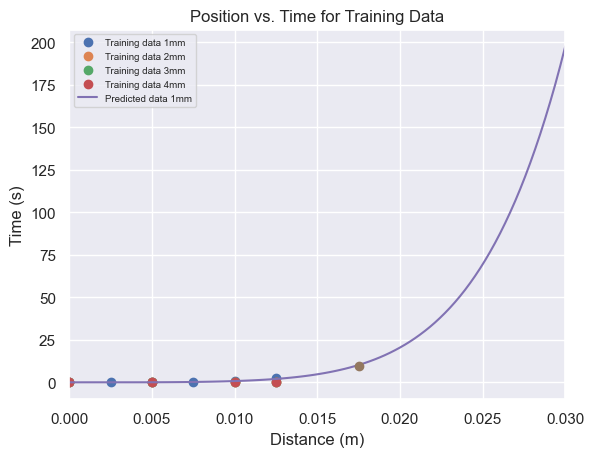

In [ ]:
'''
Plot the dimensionalized data for each droplet as well as each respective dimensionalized model
'''

# Plot dimensionalized data
plot_dim_data(show=False)

# Use nondimensionalized model to make prediction
xs = np.linspace(0, 0.03, 100)

# Plot dimensionalized model
# for i in range(0, len(different_droplet_networks)):
for i in range(0, 1):
    preds = different_droplet_networks[i].predict(xs)
    plt.plot(xs, preds)
    plt.plot(test[i]['DISTANCE'], test[i]['TIME'], 'o')
    dim_legend.append(f'Predicted data {i+1}mm')
plt.xlim(0, 0.03)
plt.legend(dim_legend, fontsize=7)
plt.show()



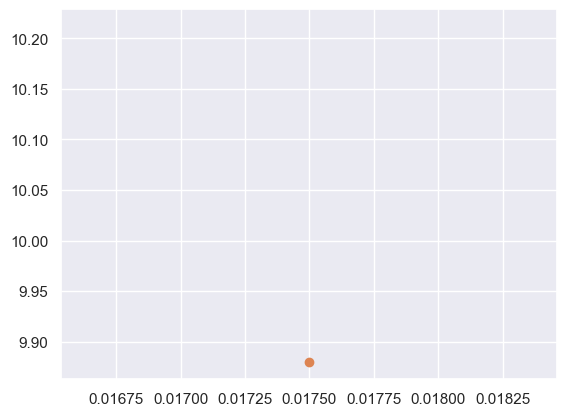

[[-0.33218872]]


In [ ]:
pred_distances = test[0]['DISTANCE']
pred_distances = np.array(pred_distances)
pred_times = different_droplet_networks[0].predict(pred_distances)
plt.plot(pred_distances, pred_times)
plt.plot(test[0]['DISTANCE'], test[0]['TIME'], 'o')
plt.show()
print(np.array(test[0]['TIME']) - pred_times)